In [0]:
NB_EPOCHS = 300
BATCH_SIZE = 256
KFOLD = 5

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import gc, sys
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

tf.__version__

'2.0.0'

##Rebuild train and test sets from input files
1. upload the interactions_train.csv and interactions_test.csv
2. execute next cell

In [4]:
train_set=pd.read_csv('./interactions_train_alt.csv').dropna()
test_matrix=pd.read_csv('./interactions_test_alt.csv').dropna()

full_data = pd.concat([train_set, test_matrix])

full_matrix = full_data.pivot_table(index='u', columns='i', values='rating', dropna=False)
print(f'Shape of fullMatrix User-Movie-Matrix:\t{full_matrix.shape}')

Shape of fullMatrix User-Movie-Matrix:	(6384, 3148)


In [0]:
#remplace rating from 0 to 5 to a boolean information : > 3 like (1), otherwise dislike (0)
full_matrix = full_matrix.applymap(lambda x : x if np.isnan(x) else int(x>3))

In [0]:
#replace all missing rating by -1 (as rating are from 0 to 5)
#the -1 will be then used in the model loss function as a mask
full_matrix.fillna(-1, inplace=True)

In [7]:
full_matrix

i,66,112,120,156,193,201,267,279,284,324,361,505,532,617,630,648,669,674,685,697,708,740,743,786,881,882,903,945,946,976,983,994,1022,1074,1080,1224,1334,1601,1632,1646,...,175772,175807,175886,176014,176120,176215,176248,176271,176310,176345,176352,176368,176491,176543,176551,176565,176663,176716,176719,176758,176824,176868,176939,177020,177109,177124,177130,177182,177367,177420,177496,177548,177550,177592,177796,177839,177884,178034,178044,178094
u,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23919,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
24240,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
24244,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.

#Build the model

In [0]:
def BuildAEModel(n_recipes, activation=None):
    inputs = tf.keras.layers.Input((n_recipes,))
    #encoded_layer1 = tf.keras.layers.Dense(8192,activation=None, name='Encoder_Layer_1')(inputs)
    #encoded_layer2 = tf.keras.layers.Dense(4096,activation=None, name='Encoder_Layer_2')(inputs)
    #encoded_layer3 = tf.keras.layers.Dense(2048,activation=None, name='Encoder_Layer_3')(inputs)
    
    embedded = tf.keras.layers.Dense(256,activation=activation, name='embedder')(inputs)
    
    #decoded_layer1 = tf.keras.layers.Dense(2048,activation=None, name='Decoder_Layer_1')(embedded)
    #decoded_layer2 = tf.keras.layers.Dense(4096,activation=None, name='Decoder_Layer_2')(decoded_layer1)
    #decoded_layer3 = tf.keras.layers.Dense(8192,activation=None, name='Decoder_Layer_3')(decoded_layer2)
    
    outputs = tf.keras.layers.Dense(n_recipes, activation='linear', name = 'Reconstructor')(embedded)
    
    model = tf.keras.Model(inputs=inputs, outputs = [outputs])
    return model

## define a specific loss function 
- to compare recipes rating for only rated recipes, ie recipes that have values <> -1
- For those recipes, mse will be computed

In [0]:
def customMaskedMSE(ytrue, ypred):
  mask = tf.not_equal(ytrue, -1)
  return tf.keras.backend.mean(tf.keras.backend.square(tf.boolean_mask(ytrue - ypred, mask)))

def customMaskedMAE(ytrue, ypred):
  mask = tf.not_equal(ytrue, -1)
  return tf.keras.backend.mean(tf.keras.backend.abs(tf.boolean_mask(ytrue - ypred, mask)))

## start the training

In [10]:
#training of model on full data set
my_model = BuildAEModel(full_matrix.shape[1], 'relu')
my_model.summary()
adam = tf.keras.optimizers.Adam(0.001)
my_model.compile('adam',loss=customMaskedMSE)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3148)]            0         
_________________________________________________________________
embedder (Dense)             (None, 256)               806144    
_________________________________________________________________
Reconstructor (Dense)        (None, 3148)              809036    
Total params: 1,615,180
Trainable params: 1,615,180
Non-trainable params: 0
_________________________________________________________________


In [11]:
hist = my_model.fit(full_matrix.values, full_matrix.values,
                    epochs=NB_EPOCHS, batch_size=BATCH_SIZE)

Train on 6384 samples
Epoch 1/300
6384/6384 [==============================] - 2s 243us/sample - loss: 0.2967
Epoch 2/300
6384/6384 [==============================] - 0s 26us/sample - loss: 0.0873
Epoch 3/300
6384/6384 [==============================] - 0s 26us/sample - loss: 0.0736
Epoch 4/300
6384/6384 [==============================] - 0s 27us/sample - loss: 0.0753
Epoch 5/300
6384/6384 [==============================] - 0s 27us/sample - loss: 0.0764
Epoch 6/300
6384/6384 [==============================] - 0s 26us/sample - loss: 0.0752
Epoch 7/300
6384/6384 [==============================] - 0s 25us/sample - loss: 0.0716
Epoch 8/300
6384/6384 [==============================] - 0s 25us/sample - loss: 0.0715
Epoch 9/300
6384/6384 [==============================] - 0s 25us/sample - loss: 0.0676
Epoch 10/300
6384/6384 [==============================] - 0s 26us/sample - loss: 0.0676
Epoch 11/300
6384/6384 [==============================] - 0s 27us/sample - loss: 0.0668
Epoch 12/300
6384/

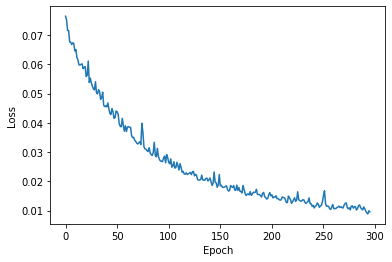

In [12]:
plt.plot(hist.history['loss'][4:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [13]:
#evaluation on the train set
my_model.evaluate(full_matrix.values, full_matrix.values, verbose=1)

6384/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.01108663520754728

# Save model on google drive for local evaluation

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
my_model.save("/content/drive/My Drive/ML/ae_v3.h5",include_optimizer=False)

##compare predictions with test data for a user
This is for quick analysis, refer to notebook DisplayReco for better analysis

In [21]:
#getting user train ratings
#id = 24240
id=33
user = full_matrix[full_matrix.index == id].T
user_ratings = user[user[id]!=-1].T

display(user_ratings)

i,2949,13616,19812,69992,72296,78451,83310,87565,97450,101200,129723,134610,135400,149428,164348,166633
u,,,,,,,,,,,,,,,,
33,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [22]:
#get predictions from model
user_train = full_matrix[full_matrix.index == id].values
preds = my_model.predict(user_train, verbose=1)
preds = pd.DataFrame(preds, columns = full_matrix.columns)

1/1 [==============================] - 0s 2ms/sample


In [23]:
#user mse
np.square(preds[user_ratings.columns].values - user_ratings.values).mean()

0.017404642100833412

In [24]:
#user prediction for train recipes
preds[user_ratings.columns]

i,2949,13616,19812,69992,72296,78451,83310,87565,97450,101200,129723,134610,135400,149428,164348,166633
0,1.010944,-0.017638,0.943129,-0.007273,0.922793,0.98955,0.033852,0.984327,1.052626,0.955344,1.016191,0.701446,0.974475,1.017623,0.402909,0.900822


In [25]:
#top 10 recipes
reco = preds[set(preds.columns) - set (user_ratings.columns)].T.sort_values([0],ascending=False)
reco_top10 = reco.head(10)
display(reco_top10)
reco_top10.index

,0
i,
37397,1.654163
31342,1.584497
148545,1.530520
106867,1.520369
96750,1.509151
44513,1.481694
126036,1.462907
14650,1.452775
101550,1.440389


Int64Index([37397, 31342, 148545, 106867, 96750, 44513, 126036, 14650, 101550,
            50013],
           dtype='int64', name='i')